# Exercises for the course "Declarative Problem Solving Paradigms in AI"

In [1]:
# Imports (some dependency errors may appear, you can ignore them for now)
# !pip install cpmpy numpy colorama networkx matplotlib requests z3-solver --quiet

import cpmpy as cp

## **Session 2: Reification, solving, debugging and explaining**

Welcome to the second exercise session of Declarative Problem Solving Paradigms in AI. In this session, we will cover a collection of concepts you would need to master as to efficiently and effectively create Constraint Programming models of your own:


1) Debugging

2) Solving

3) Explaining

4) Reification

We will cover each of them in a separate section; guiding you through an example, followed by a modelling exercise.

**Useful Resources:**
* CPMpy documentation: https://cpmpy.readthedocs.io/en/latest/index.html
* CPMpy quickstart: https://cpmpy.readthedocs.io/en/latest/modeling.html

### **Part 3: Explaining**

In this section, we'll cover the topic of "*eXplainable Constraint Programming*" (XCP). The motivation is as follows:

You're working on a CP model for a problem you want solved. Using all the knowledge you've already gained from this course, and after a lot of debugging, the model has been completed. Time to solve it! But what now? No errors, but still not the answer you expected.

It could be:
- UNSAT
- a strange solution
- a not good enough solution

How do we fix this? The model has no syntactical errors, but maybe it has modeling errors (does not encode the problem you actually intended). Or maybe you would just like to better understand why you got a certain (non-) solution or why the current one is the most optimal (why not better?). This is where **explainable AI** comes into play, since the solver acts as a black box.

As seen in the lectures, there are 2 patterns of explanations:
- **Deductive**: How was X derived? (Why I didn’t get any solution?)
- **Counterfactual** Why X and not Z ? (How can I make it satisfiable?)

To better understand these types of explanations, and how they can be "derived" from our model specification, we'll quickly go through the same example as seen in the lecture: the **Graph Coloring Problem**.

#### **0. Setup**

In [2]:
# Support code fo the 'Graph Coloring Problem'
from typing import List
import matplotlib.pyplot as plt
import networkx as nx
import re
from cpmpy.expressions.utils import flatlist

def draw(g, **kwargs) -> None:
    nx.draw_circular(g, width=5, node_size=500, **kwargs)
    plt.show()

cmap = plt.get_cmap('tab10').colors #["black", "yellow", "cyan", "lightgreen", "blue"]

def get_colors(color:List[int]) -> List[str]:
    return [cmap[c] for c in color]

def show_graph(nodes, edges, color=[], conflicts=[], satisfiable=[], corrections=[], **kwargs) -> None:
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)

    conflicts = flatlist(conflicts)
    satisfiable = flatlist(satisfiable)
    corrections = flatlist(corrections)

    conflict_edges = []
    for c in conflicts:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        conflict_edges.append((a, b))

    sat_edges = []
    for c in satisfiable:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        sat_edges.append((a, b))

    correction_edges = []
    for c in corrections:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        correction_edges.append((a, b))

    colors = ["red" if (a, b) in conflict_edges else ("green" if (a,b) in sat_edges else ("orange" if (a,b) in correction_edges else "black")) for (a, b) in graph.edges()]
    if len(color) != 0:
        kwargs |= {"node_color": get_colors(color)}
    draw(graph, edge_color=colors, **kwargs)


#### **1. Graph Coloring Problem**

We've already seen the **Graph Coloring Problem** in the lectures. The problem description is as follows:

  "*Given a graph, consisting of nodes and interconnecting edges, assign to each of the nodes a color such that no two adjacent nodes (with an edge in between) have the same color.*"
    
A trivial solution is of course to give each node its own unique color so we never have "clashing" neighbors. To exclude this trivial setting, the problem often also specifies a maximum number of colors that might be used (lower than the number of nodes) and might additionally challenge you to find a solution with the least number of colors.

Let's look at an example graph:

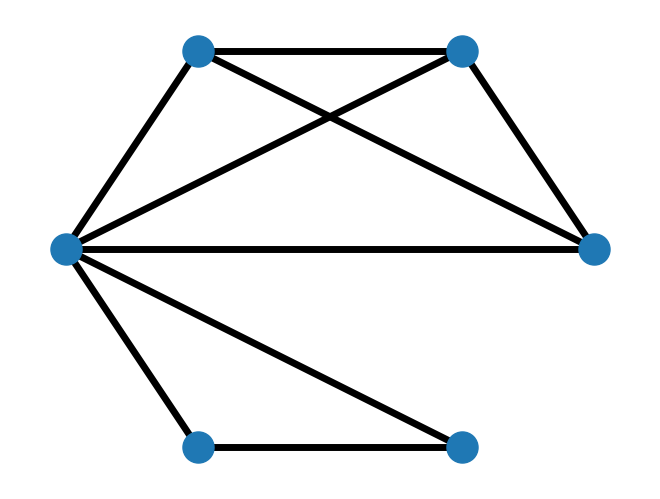

In [3]:
# A collection of nodes
nodes = [0, 1, 2, 3, 4, 5]
# The edges interconnecting the nodes
# edges = [(0, 2), (0, 4), (0, 5), (1, 2), (1, 3),  (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
edges = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2,3), (3, 4), (3, 5), (4, 5)]

show_graph(nodes, edges)

And a CPMpy model for the problem:

In [4]:
from typing import Tuple

def graph_coloring_model(nodes, edges, max_nr_colors: int) -> Tuple[cp.Model, cp.IntVar]:
    # Decision Variables
    #   color[i] = j -> node i has color j
    color = cp.intvar(0, max_nr_colors, shape=len(nodes), name="color")

    # Model
    model = cp.Model()

    # Constraints
    # 1) Neighbours cannot have the same color
    model += [color[n1] != color[n2] for (n1, n2) in edges]
    # 2) Maximally 'max_nr_colors' colors
    model += (cp.max(color) < max_nr_colors)

    # Objective
    #   minimize the number of used colors
    model.minimize(cp.max(color))

    return model, color

Let's solve the coloring problem on this graph and look at the solution:

Node colors: [0 3 2 1 2 0]


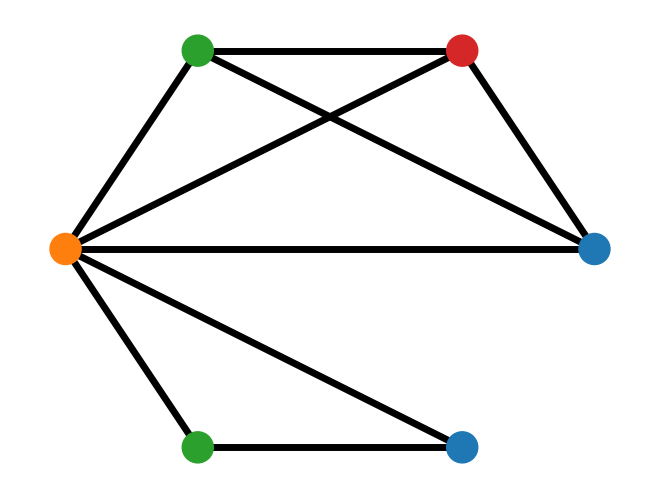

In [5]:
# Create Model
model, color = graph_coloring_model(nodes, edges, len(nodes))

# Solve
model.solve()

# Print Solution
print(f"Node colors: {color.value()}")

# Visualize Solution
show_graph(nodes, edges, color=color.value())

From looking at the solution, we can deduce that our graph requires at least 4 colors and that any less than that will not be possible (since we already modeled it as a minimization objective). If we enforce it, it should become UNSAT. To understand why, we can start using the explanation techniques / tools as seen in the lectures.

In [6]:
# Create Model
model, color = graph_coloring_model(nodes, edges, 2) # try coloring using only 2 colors

# Solve
print(model.solve())

False


The first approach is to generate a **MUS** (Minimal Unsatisfiable Subset).

A MUS is a subset of the constraints that is UNSAT, with the additional characteristic that any further subset of that MUS will become SAT; it is minimal. It explains to us **one of possibly many** points of conflict.

MUS:
   (color[0]) != (color[1])
   (color[0]) != (color[2])
   (color[0]) != (color[3])
   (color[1]) != (color[2])
   (color[1]) != (color[3])
   (color[2]) != (color[3])


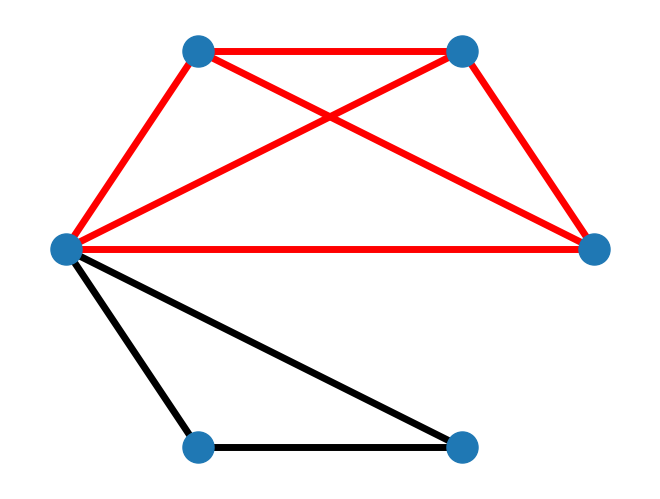

In [7]:
from cpmpy.tools.explain.mus import mus_naive as mus

model, color = graph_coloring_model(nodes, edges, 2) # enforce the use of 2 colors

# Call the 'mus' tool
MUS = mus(model.constraints)

# Print the constraints inside the MUS
print("MUS:")
for constraint in MUS:
    print("  ", constraint)

# Visualize the MUS
show_graph(nodes, edges, conflicts=MUS)

Now we have an explanation for the UNSAT; our graph consists of a 4-clique and such a clique needs at least 4 colors. We've been able to pinpoint **a** possible cause of conflict and explain it in a minimal and understandable way.

But this explanation is not the smallest that we can find. In the lecture we saw that many MUSes may exist, many ways of explaining the same unsatisfiability through different "points of conflict". Imagine we have a preference as to how we would like our explanation. How can we influence which MUS gets shown?

This is a task for an **Optimal Unsatisfiable Subset** (OUS). It expects a set of weights for the different constraints and then finds a MUS which is optimal in regard to the sum of the weights of the included constraints. Providing equal or no weights, will result in finding the smallest MUS.

OUS:
   (color[3]) != (color[4])
   (color[3]) != (color[5])
   (color[4]) != (color[5])
   max(color[0],color[1],color[2],color[3],color[4],color[5]) < 2


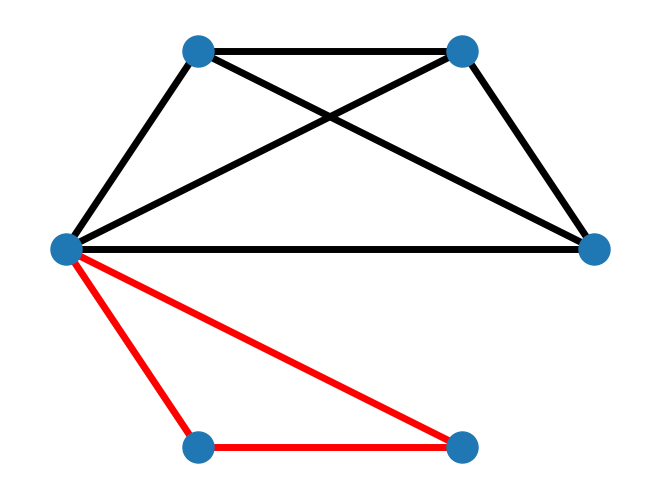

In [8]:
from cpmpy.tools.explain.mus import optimal_mus

model, color = graph_coloring_model(nodes, edges, 2) # enforce the use of 2 colors

# Call the 'optimal_mus' tool
OUS = optimal_mus(model.constraints) # don't provide any weights = assume all constraints have equal weights

# Print the constraints inside the OUS
print("OUS:")
for constraint in OUS:
    print("  ", constraint)

# Visualize the OUS
show_graph(nodes, edges, conflicts=OUS)

We can thus already explain the UNSAT with a smaller MUS; a 3-clique.

Next we can make explanations using a **Maximal Satisfiable Subset** (MSS). It has a definition a bit of the opposite of a MUS. Now we have a subset of constraints which is SAT, but if we add any more constraints (of the original problem), the model becomes UNSAT; the subset is maximal. This explains to us which smaller sub-problem would be SAT.

MSS:
   (color[0]) != (color[1])
   (color[0]) != (color[2])
   (color[1]) != (color[3])
   (color[2]) != (color[3])
   (color[3]) != (color[5])
   (color[4]) != (color[5])
   max(color[0],color[1],color[2],color[3],color[4],color[5]) < 2


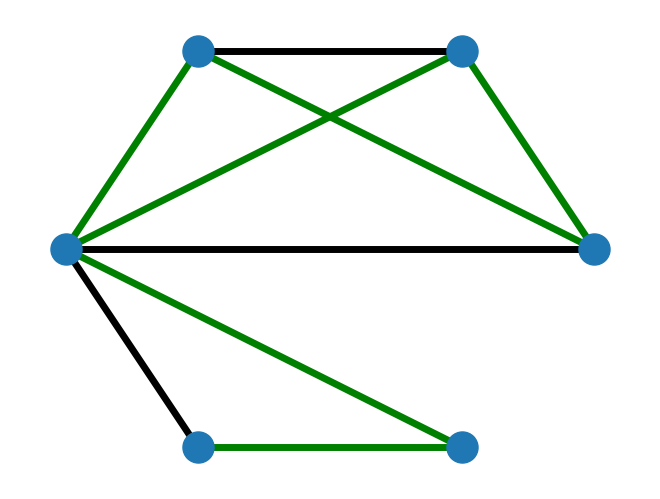

In [9]:
from cpmpy.tools.explain.mss import mss

model, color = graph_coloring_model(nodes, edges, 2) # enforce the use of 2 colors

# Call the 'mss' tool
MSS = mss(model.constraints, hard=[cp.max(color) < 2]) # added as hard constraint to make sure it is included in the MSS

# Print the constraints inside the MSS
print("MSS:")
for constraint in MSS:
    print("  ", constraint)

# Visualize the MSS
show_graph(nodes, edges, satisfiable=MSS)

So if we kept only these edges, the problem would become SAT. The complement of a MSS is a **Minimal Correction Subset** (MCS), which we can use to explain what needs to be removed (corrected) to make the problem SAT.

MCS:
   (color[0]) != (color[3])
   (color[1]) != (color[2])
   (color[3]) != (color[4])


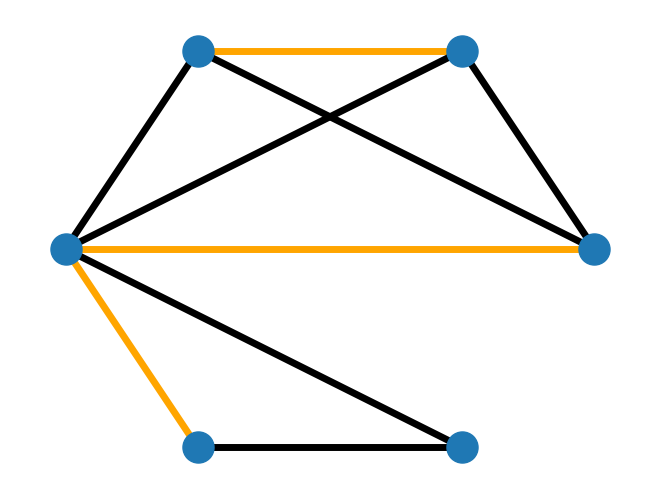

In [10]:
from cpmpy.tools.explain.mcs import mcs

model, color = graph_coloring_model(nodes, edges, 2) # enforce the use of 2 colors

# Call the 'mcs' tool
MCS = mcs(model.constraints, hard=[cp.max(color) < 2]) # added as hard constraint to make sure it is NOT included in the MCS

# Print the constraints inside the MCS
print("MCS:")
for constraint in MCS:
    print("  ", constraint)

# Visualize the MCS
show_graph(nodes, edges, corrections=MCS)

So removing all the edges that create cliques of side 3 or greater.

#### **2. Alignment Photo Problem**

Now it is your turn.

You are tasked with organizing students into a single line for a class photo. Some of the students have specific friends they insist on standing next to. These requests get specified as a collection of wishes *(who, whom)* indicating "*who*" wants to stand next to "*whom*". You need to arrange the students while respecting these friendship constraints.

##### **Setup**

In [11]:
# Support code

import matplotlib.pyplot as plt
import requests
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from io import BytesIO
from cpmpy.expressions.utils import flatlist

# Function to download emoji image from the web
def download_emoji(emoji_code):
    response = requests.get(f"https://github.com/twitter/twemoji/raw/master/assets/72x72/{emoji_code}.png")
    return Image.open(BytesIO(response.content)).convert('RGBA')  # Convert to RGBA for transparency support

# Function to convert emoji to unicode code for image link (e.g., 😃 -> 1f603)
def emoji_to_unicode(emoji):
    return '-'.join(f"{ord(c):x}" for c in emoji)

# Function to show a nice graph of the students and their wishes
def show_graph(people, wishes, pos=None, conflict=[], correction=[], satisfiable=[]):
    # Check solution legality
    if pos is not None:
        if len(set(pos)) < len(pos):
            raise ValueError('Two students are standing at the same location, this is not allowed!')

    # Create networkX graph
    G = nx.Graph()
    G.add_nodes_from(list(range(len(people))))
    G.add_edges_from([(who, whom) for (who,whom) in wishes])
    nx_pos = nx.circular_layout(G)

    # Create figure
    fig, ax = plt.subplots()
    nx.draw(G, nx_pos, with_labels=False, node_size=2000, node_color="white", font_size=20, font_color="black", ax=ax)
    nx.draw_networkx_labels(G, nx_pos)

    conflict = flatlist(conflict)
    correction = flatlist(correction)
    satisfiable = flatlist(satisfiable)

    conflict_edges = []
    for c in conflict:
        if c.name == "alldifferent": continue
        n1, n2 = c.args
        if n1.name == "max": continue
        if n1.name == "abs": n1, n2 = n1.args[0].args
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        conflict_edges.append((min(a, b), max(a, b)))

    sat_edges = []
    for c in satisfiable:
        if c.name == "alldifferent": continue
        n1, n2 = c.args
        if n1.name == "max": continue
        if n1.name == "abs": n1, n2 = n1.args[0].args
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        sat_edges.append((min(a, b), max(a, b)))

    correction_edges = []
    for c in correction:
        if c.name == "alldifferent": continue
        n1, n2 = c.args
        if n1.name == "max": continue
        if n1.name == "abs": n1, n2 = n1.args[0].args
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        correction_edges.append((min(a, b), max(a, b)))

    colors = ["red" if (a, b) in conflict_edges else ("green" if (a,b) in sat_edges else ("orange" if (a,b) in correction_edges else "black")) for (a, b) in G.edges()]

    # Color edges
    nx.draw_networkx_edges(G, nx_pos, edgelist=G.edges(), edge_color=colors, width=2, ax=ax)
    if pos is not None: # if a solution position is provided
        green_edges = [wish for wish in wishes if abs(pos[wish[0]] - pos[wish[1]]) == 1]
        nx.draw_networkx_edges(G, nx_pos, edgelist=G.edges(), edge_color='red', width=2, ax=ax)
        nx.draw_networkx_edges(G, nx_pos, edgelist=green_edges, edge_color='green', width=2, ax=ax)

    # Loop through nodes and place emoji images on them
    for node, (x, y) in nx_pos.items():
        emoji_unicode = emoji_to_unicode(people[node])
        emoji_img = download_emoji(emoji_unicode)
        imagebox = OffsetImage(emoji_img, zoom=0.5)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    plt.tight_layout()
    plt.show()

##### **Problem**

In [12]:
# Parameters of the problem
students = ["😀", "😇", "😎", "🤠", "🤩", "🧐", "🤕"]
wishes = [(1, 4), (4, 0), (2, 1), (3, 0)] # pairs of indexes into the list of students

def photo_alignment(students, wishes):
    N = len(students)

    # Decision variables
    pos = cp.intvar(0, N-1, shape=N, name="pos")

    # Model
    model = cp.Model()

    # Constraints
    """
    TODO: Fill in the constraints according to the problem description whilst enforcing all student wishes.

    HINT: Students who stand next to each other will have a distance of 1 between them (their 'pos').
          Use cp.abs(...) to get the absolute value of an expression.

    HINT: Don't forget that only one student can stand at the same location.
    """
    model += cp.AllDifferent(pos)
    model += [cp.abs(pos[wish[0]] - pos[wish[1]]) == 1 for wish in wishes]

    # Solve
    sat = model.solve()

    # Show solution
    if sat:
        print("Found a solution:")
        print(f"Student positions: {pos.value()}")
    else:
        print("Problem is UNSAT")

    return model, pos

model, pos = photo_alignment(students, wishes)

Found a solution:
Student positions: [5 3 2 6 4 0 1]


If the above result looks right, we can now visualize the problem as a graph and highlight our compliance with the student wishes:

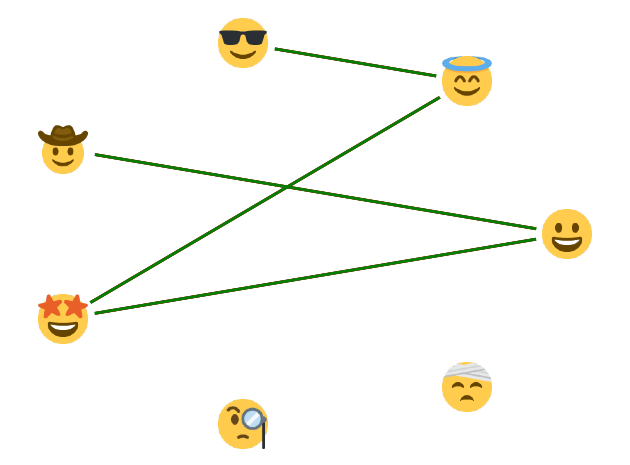

In [13]:
show_graph(students, wishes, pos=pos)

All edges should be green, indicating that all our student wishes are satisfied.



Let's try again with a different set of wishes

In [14]:
# Parameters of the problem
students = ["😀", "😇", "😎", "🤠", "🤩", "🧐", "🤕"]
wishes = [(1, 4), (4, 0), (5, 4), (5, 2), (2, 1), (6, 4), (3, 0), (4, 2), (6, 3), (0, 5)] # pairs of indexes into the list of students

model, pos = photo_alignment(students, wishes)

Problem is UNSAT


It should be UNSAT.

Use CPMpy's set of tools to explain a point of conflict in this problem. Interpret what this explanation means.

Problem is UNSAT
Conflict:
   abs((pos[5]) + (-(pos[4]))) == 1
   abs((pos[5]) + (-(pos[2]))) == 1
   abs((pos[4]) + (-(pos[2]))) == 1


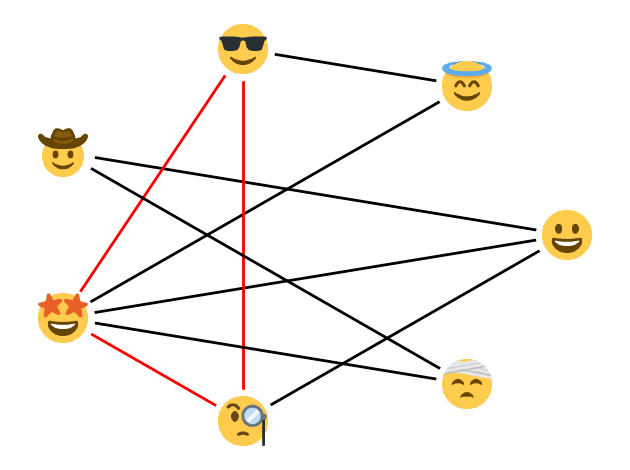

In [15]:
model, pos = photo_alignment(students, wishes)

"""
TODO: Use the applicable CPMpy tool to compute a point of conflict in our problem.
"""

conflict = optimal_mus(model.constraints) # update with result of an explanation tool


# Print conflict
print("Conflict:")
for constraint in conflict:
    print("  ", constraint)

# Visualize conflict
show_graph(students, wishes, conflict=conflict)

Now explain what compromises to the "wishes" need to be made in order to make the problem SAT?

Problem is UNSAT
Correction:
   abs((pos[4]) + (-(pos[2]))) == 1
   alldifferent(pos[0],pos[1],pos[2],pos[3],pos[4],pos[5],pos[6])
   abs((pos[0]) + (-(pos[5]))) == 1


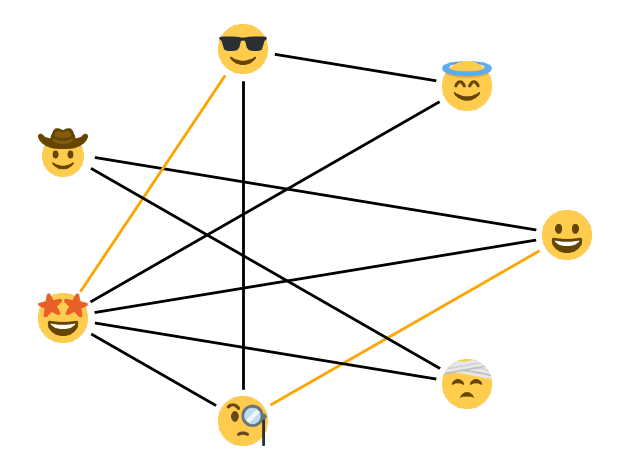

In [16]:
model, pos = photo_alignment(students, wishes)

"""
TODO: Use the applicable CPMpy tool to compute which correction needs to be made.
      (there may be multiple alternative options)

HINT: We only want to make corrections to the wishes, so make sure only these constraints can be part of the correction.
      You can pass to the tool a list of constraint which should not be correct via the 'hard' argument.
"""

correction = mcs(model.constraints) # update with result of an explanation tool


# Print correction
print("Correction:")
for constraint in correction:
    print("  ", constraint)

# Visualize correction
show_graph(students, wishes, correction=correction)

Problem is UNSAT
Correction:
   abs((pos[4]) + (-(pos[2]))) == 1
   abs((pos[5]) + (-(pos[4]))) == 1
   abs((pos[6]) + (-(pos[4]))) == 1
   abs((pos[0]) + (-(pos[5]))) == 1


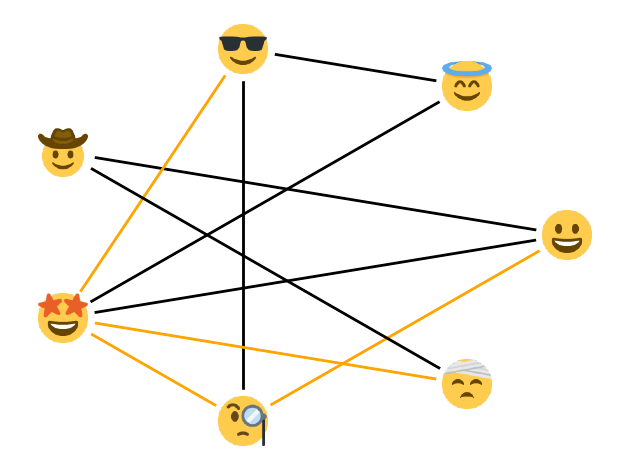

In [17]:
model, pos = photo_alignment(students, wishes)

"""
TODO: Use the applicable CPMpy tool to compute which correction needs to be made.
      (there may be multiple alternative options)

HINT: We only want to make corrections to the wishes, so make sure only these constraints can be part of the correction.
      You can pass to the tool a list of constraint which should not be correct via the 'hard' argument.
"""

correction = mcs(model.constraints, hard=[cp.AllDifferent(pos)]) # update with result of an explanation tool


# Print correction
print("Correction:")
for constraint in correction:
    print("  ", constraint)

# Visualize correction
show_graph(students, wishes, correction=correction)

To check your solution, the removal of 4 wishes should be sufficient.

This type of explanation is called a **Counterfactual explanation**:

    How to change the model, in order to find a solution?
    - Find constraints that, if removed, a solution can be found!
    - Find a correction subset . . .

Another type of explanation is that of "**Explaining logical consequences**". See the lecture for more information.

